In [1]:
#Setup and Installation
!nvidia-smi
!git clone --recursive https://github.com/graphdeco-inria/gaussian-splatting.git
%cd gaussian-splatting

!pip install -q plyfile tqdm pillow opencv-python
!pip install -q submodules/diff-gaussian-rasterization
!pip install -q submodules/simple-knn

!apt-get install -y colmap imagemagick ffmpeg

import torch
import os
print(f"PyTorch: {torch.__version__}")
print(f"CUDA: {torch.cuda.is_available()}")
print(f"GPU: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'None'}")

Sat Jan 17 13:33:33 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.172.08             Driver Version: 570.172.08     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   31C    P0             25W /  250W |       0MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
!mkdir -p /kaggle/working/lego

!cp -r /kaggle/input/nerf-synthetic-dataset/nerf_synthetic/lego/ \
      /kaggle/working/lego/

## EDA: LEGO Dataset (NeRF Synthetic)

Dataset Split Distribution:
  train: 100 images
  val: 100 images
  test: 400 images
  Total: 600 images


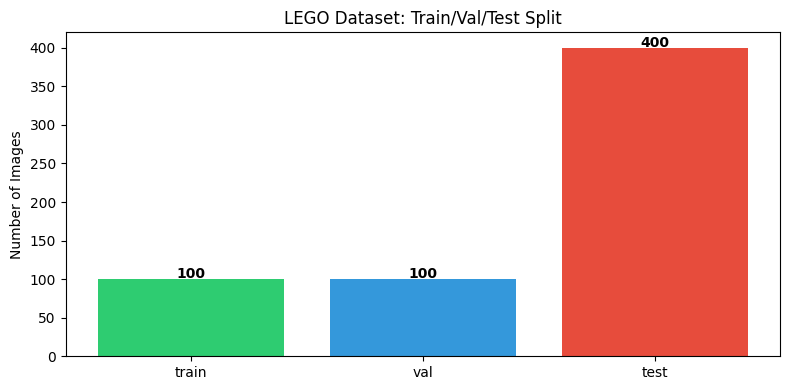

In [3]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from collections import Counter

LEGO_PATH = '/kaggle/working/lego/lego'

splits = ['train', 'val', 'test']
split_counts = {}
for split in splits:
    split_path = os.path.join(LEGO_PATH, split)
    if os.path.exists(split_path):
        images = [f for f in os.listdir(split_path) if f.endswith('.png')]
        split_counts[split] = len(images)

print("Dataset Split Distribution:")
for split, count in split_counts.items():
    print(f"  {split}: {count} images")
print(f"  Total: {sum(split_counts.values())} images")

plt.figure(figsize=(8, 4))
plt.bar(split_counts.keys(), split_counts.values(), color=['#2ecc71', '#3498db', '#e74c3c'])
plt.title('LEGO Dataset: Train/Val/Test Split')
plt.ylabel('Number of Images')
for i, (k, v) in enumerate(split_counts.items()):
    plt.text(i, v + 1, str(v), ha='center', fontweight='bold')
plt.tight_layout()
plt.show()

Camera Field of View: 39.60°
Number of Camera Poses (train): 100

Camera Position Statistics:
  X range: [-3.94, 3.72]
  Y range: [-3.93, 3.95]
  Z range: [0.51, 4.03]


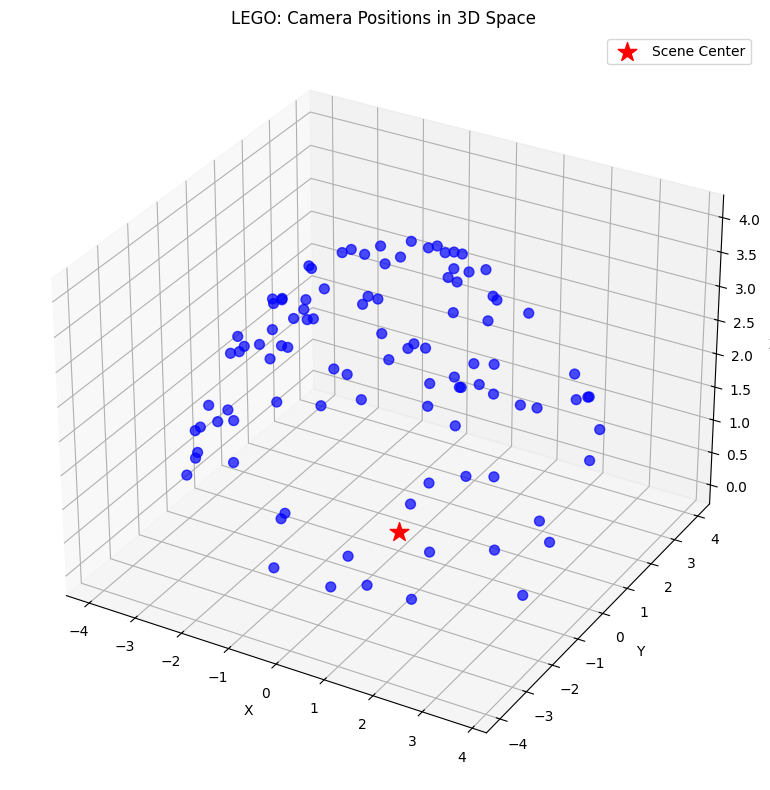

In [4]:
with open(os.path.join(LEGO_PATH, 'transforms_train.json'), 'r') as f:
    transforms = json.load(f)

fov = transforms.get('camera_angle_x', 0)
print(f"Camera Field of View: {np.degrees(fov):.2f}°")
print(f"Number of Camera Poses (train): {len(transforms['frames'])}")

camera_positions = []
for frame in transforms['frames']:
    matrix = np.array(frame['transform_matrix'])
    position = matrix[:3, 3]
    camera_positions.append(position)
camera_positions = np.array(camera_positions)

print(f"\nCamera Position Statistics:")
print(f"  X range: [{camera_positions[:,0].min():.2f}, {camera_positions[:,0].max():.2f}]")
print(f"  Y range: [{camera_positions[:,1].min():.2f}, {camera_positions[:,1].max():.2f}]")
print(f"  Z range: [{camera_positions[:,2].min():.2f}, {camera_positions[:,2].max():.2f}]")

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(camera_positions[:,0], camera_positions[:,1], camera_positions[:,2], c='blue', s=50, alpha=0.7)
ax.scatter(0, 0, 0, c='red', s=200, marker='*', label='Scene Center')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('LEGO: Camera Positions in 3D Space')
ax.legend()
plt.tight_layout()
plt.show()

Image Shape: (800, 800, 4)
Image Size: 800x800
Channels: 4 (RGBA)
Data Type: uint8
Pixel Value Range: [0, 255]


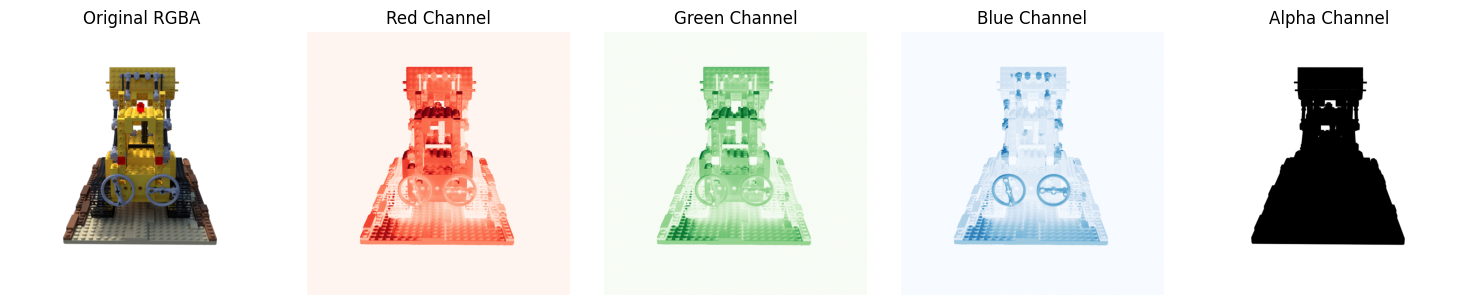

In [5]:
sample_img_path = os.path.join(LEGO_PATH, 'train', 'r_0.png')
img = Image.open(sample_img_path)
img_array = np.array(img)

print(f"Image Shape: {img_array.shape}")
print(f"Image Size: {img.size[0]}x{img.size[1]}")
print(f"Channels: {img_array.shape[2]} (RGBA)" if len(img_array.shape) > 2 else "Grayscale")
print(f"Data Type: {img_array.dtype}")
print(f"Pixel Value Range: [{img_array.min()}, {img_array.max()}]")

fig, axes = plt.subplots(1, 5, figsize=(15, 3))
axes[0].imshow(img)
axes[0].set_title('Original RGBA')
for i, (channel, color, name) in enumerate(zip([0,1,2,3], ['Reds','Greens','Blues','Greys'], ['Red','Green','Blue','Alpha'])):
    axes[i+1].imshow(img_array[:,:,channel], cmap=color)
    axes[i+1].set_title(f'{name} Channel')
for ax in axes:
    ax.axis('off')
plt.tight_layout()
plt.show()

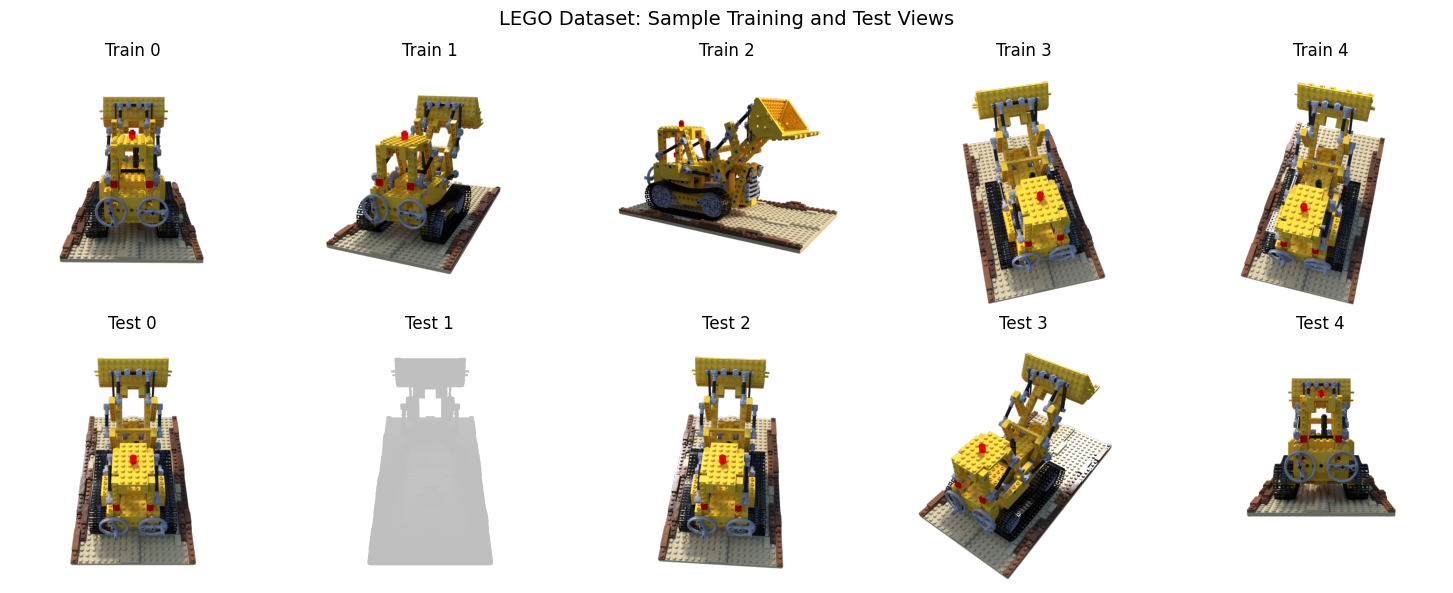

In [6]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
train_images = sorted([f for f in os.listdir(os.path.join(LEGO_PATH, 'train')) if f.endswith('.png')])[:5]
test_images = sorted([f for f in os.listdir(os.path.join(LEGO_PATH, 'test')) if f.endswith('.png')])[:5]

for i, img_name in enumerate(train_images):
    img = Image.open(os.path.join(LEGO_PATH, 'train', img_name))
    axes[0, i].imshow(img)
    axes[0, i].set_title(f'Train {i}')
    axes[0, i].axis('off')

for i, img_name in enumerate(test_images):
    img = Image.open(os.path.join(LEGO_PATH, 'test', img_name))
    axes[1, i].imshow(img)
    axes[1, i].set_title(f'Test {i}')
    axes[1, i].axis('off')

plt.suptitle('LEGO Dataset: Sample Training and Test Views', fontsize=14)
plt.tight_layout()
plt.show()

In [12]:
# CELL 3: Convert Dataset
SCENE_NAME = 'lego'
SOURCE_PATH = f'/kaggle/working/lego/{SCENE_NAME}'

!python convert.py -s {SOURCE_PATH}

print(f"Data converted for scene: {SCENE_NAME}")
!ls {SOURCE_PATH}

[option_manager.cc:811] Check failed: ExistsDir(*image_path)
ERROR: Invalid options provided.
ERROR:root:Feature extraction failed with code 256. Exiting.
Data converted for scene: lego
distorted  train		 transforms_train.json	val
test	   transforms_test.json  transforms_val.json


In [13]:
# CELL 5: Train Model (Quick - 7000 iterations)
import time

MODEL_PATH = f'output/models/{SCENE_NAME}'
ITERATIONS = 7000

os.makedirs(MODEL_PATH, exist_ok=True)

train_cmd = f"""
python train.py \
    -s {SOURCE_PATH} \
    -m {MODEL_PATH} \
    --iterations {ITERATIONS} \
    --test_iterations 1000 3000 7000 \
    --save_iterations 1000 3000 7000 \
    --checkpoint_iterations 1000 3000 7000 \
    --resolution 1 \
    --eval
"""

print("Starting training...")
start_time = time.time()
!{train_cmd}
end_time = time.time()

print(f"\nTraining completed in {(end_time - start_time) / 60:.2f} minutes")

Starting training...
2026-01-17 13:42:16.926637: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1768657336.948339    1038 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1768657336.955187    1038 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1768657336.972596    1038 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768657336.972625    1038 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768657336.972628    1038 computation_placer.cc:177] c

In [14]:
# CELL 6: Render Test Views
RENDER_PATH = f'output/renders/{SCENE_NAME}'

render_cmd = f"""
python render.py \
    -m {MODEL_PATH} \
    --skip_train \
    --iteration 7000
"""

print("Rendering test views...")
!{render_cmd}

print(f"Renders saved to: {MODEL_PATH}/test/ours_7000/renders")

Rendering test views...
Looking for config file in output/models/lego/cfg_args
Config file found: output/models/lego/cfg_args
Rendering output/models/lego
Loading trained model at iteration 7000 [17/01 13:48:22]
Found transforms_train.json file, assuming Blender data set! [17/01 13:48:22]
Reading Training Transforms [17/01 13:48:22]
Reading Test Transforms [17/01 13:48:27]
Loading Training Cameras [17/01 13:48:36]
Loading Test Cameras [17/01 13:48:39]
Rendering progress: 100%|█████████████████████| 200/200 [01:03<00:00,  3.15it/s]
Renders saved to: output/models/lego/test/ours_7000/renders


In [15]:
# CELL 7: Evaluate Model
eval_cmd = f"""
python metrics.py \
    -m {MODEL_PATH}
"""

print("Evaluating model...")
!{eval_cmd}

Evaluating model...

Scene: output/models/lego
Method: ours_7000
Metric evaluation progress:   0%|                       | 0/200 [00:00<?, ?it/s]Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth

  0%|                                                | 0.00/528M [00:00<?, ?B/s]
  2%|▊                                       | 10.6M/528M [00:00<00:04, 111MB/s]
  7%|██▋                                     | 34.8M/528M [00:00<00:02, 194MB/s]
 11%|████▍                                   | 59.0M/528M [00:00<00:02, 221MB/s]
 16%|██████▎                                 | 83.2M/528M [00:00<00:01, 234MB/s]
 20%|████████▎                                | 107M/528M [00:00<00:01, 238MB/s]
 25%|██████████▏                              | 130M/528M [00:00<00:01, 241MB/s]
 29%|████████████                             | 155M/528M [00:00<00:01, 245MB/s]
 34%|█████████████▊                           | 178M/528M [00:00<00:01, 232MB/s

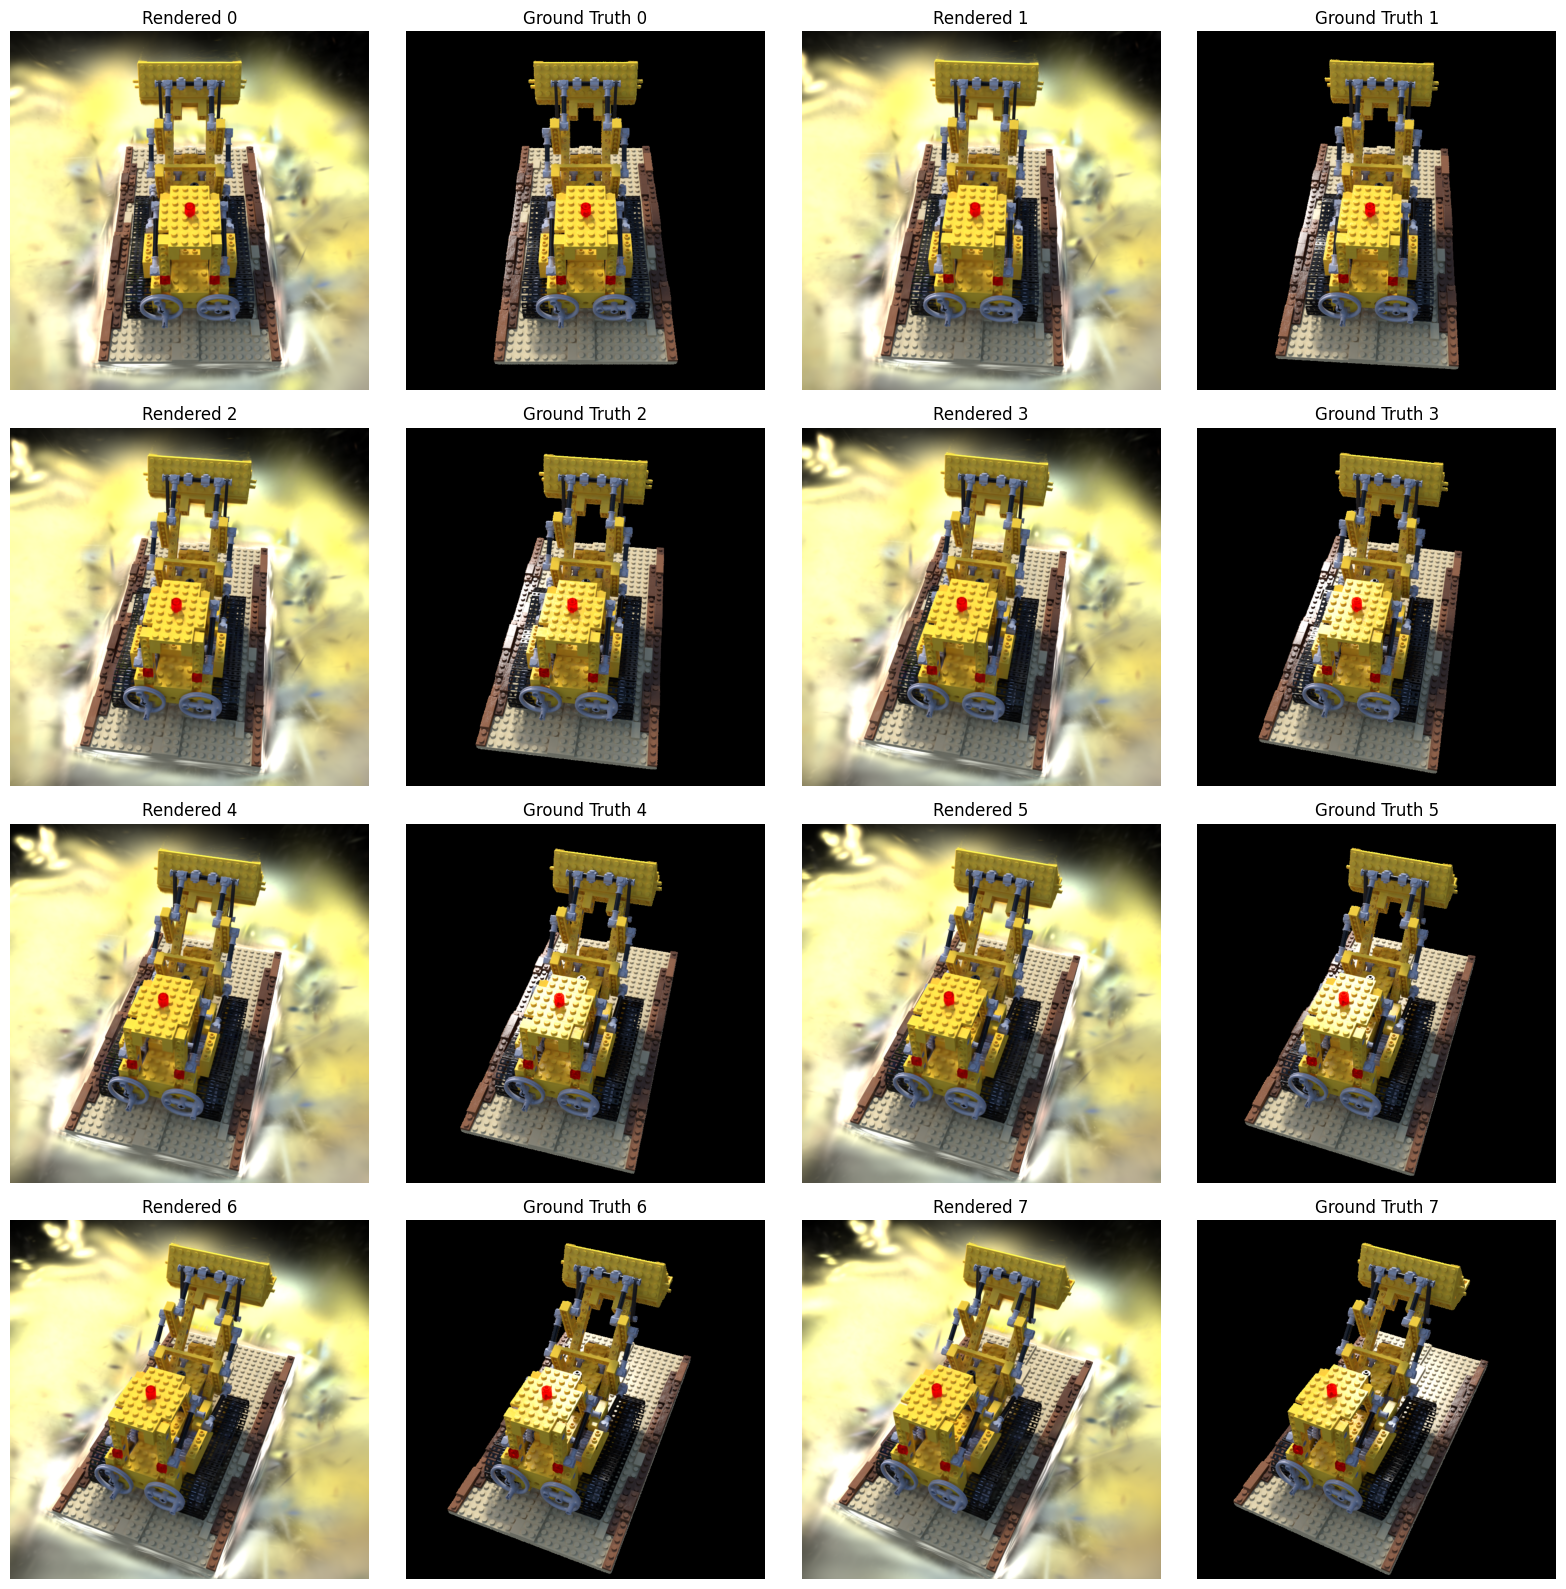

In [16]:
# CELL 8: Visualize Results
import json
import matplotlib.pyplot as plt
from PIL import Image

renders_path = f"{MODEL_PATH}/test/ours_7000/renders"
gt_path = f"{MODEL_PATH}/test/ours_7000/gt"

render_files = sorted(os.listdir(renders_path))[:8]

fig, axes = plt.subplots(4, 4, figsize=(16, 16))

for idx, img_file in enumerate(render_files):
    render_img = Image.open(os.path.join(renders_path, img_file))
    gt_img = Image.open(os.path.join(gt_path, img_file))
    
    axes[idx*2//4, (idx*2)%4].imshow(render_img)
    axes[idx*2//4, (idx*2)%4].set_title(f'Rendered {idx}')
    axes[idx*2//4, (idx*2)%4].axis('off')
    
    axes[idx*2//4, (idx*2)%4 + 1].imshow(gt_img)
    axes[idx*2//4, (idx*2)%4 + 1].set_title(f'Ground Truth {idx}')
    axes[idx*2//4, (idx*2)%4 + 1].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
!cd /kaggle/working
!pwd
!zip -r point_cloud_lego_iter7000.zip \
    output/models/lego/point_cloud/iteration_7000/point_cloud.ply


In [17]:
# CELL 10: Load Metrics
results_file = f"{MODEL_PATH}/results.json"

if os.path.exists(results_file):
    with open(results_file, 'r') as f:
        results = json.load(f)
    
    print("Evaluation Metrics:")
    print("=" * 50)
    for key, value in results.items():
        if isinstance(value, dict):
            print(f"\n{key}:")
            for k, v in value.items():
                print(f"  {k}: {v}")
        else:
            print(f"{key}: {value}")
    print("=" * 50)
else:
    print("Results file not found. Run evaluation first.")

Evaluation Metrics:

ours_7000:
  SSIM: 0.29538440704345703
  PSNR: 6.033204555511475
  LPIPS: 0.46333569288253784


In [ ]:
# # CELL 12: Train Full Quality (Optional - 30000 iterations)
# FULL_MODEL_PATH = f'output/models/{SCENE_NAME}_full'
# FULL_ITERATIONS = 30000

# os.makedirs(FULL_MODEL_PATH, exist_ok=True)

# full_train_cmd = f"""
# python train.py \
#     -s {SOURCE_PATH} \
#     -m {FULL_MODEL_PATH} \
#     --iterations {FULL_ITERATIONS} \
#     --test_iterations 7000 15000 30000 \
#     --save_iterations 7000 15000 30000 \
#     --checkpoint_iterations 7000 15000 30000 \
#     --resolution 1 \
#     --eval
# """

# print("Starting full training (30000 iterations)...")
# print("This will take 20-30 minutes")

# start_time = time.time()
# !{full_train_cmd}
# end_time = time.time()

# print(f"\nFull training completed in {(end_time - start_time) / 60:.2f} minutes")

---
## Custom Room Dataset

In [18]:
import shutil
import os

input_dir = '/kaggle/input/room-processed/exhaustive_room2'
output_dir = '/kaggle/working/colmap_output'

try:
    shutil.copytree(input_dir, output_dir)
    print(f"Contents of '{input_dir}' successfully copied to '{output_dir}'.")
except FileExistsError:
    print(f"Error: '{output_dir}' already exists.")

Contents of '/kaggle/input/room-processed/exhaustive_room2' successfully copied to '/kaggle/working/colmap_output'.


## EDA: Custom Room Dataset

In [19]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2

ROOM_PATH = '/kaggle/working/colmap_output'
IMAGES_PATH = os.path.join(ROOM_PATH, 'images')

if os.path.exists(IMAGES_PATH):
    all_images = [f for f in os.listdir(IMAGES_PATH) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    print(f"Total Images: {len(all_images)}")
    
    extensions = [os.path.splitext(f)[1].lower() for f in all_images]
    ext_counts = {ext: extensions.count(ext) for ext in set(extensions)}
    print(f"Image Formats: {ext_counts}")
else:
    print("Images folder not found")
    all_images = []

Total Images: 209
Image Formats: {'.jpg': 209}


Image Dimensions: 1069x1907
Resolution Consistency: Uniform
File Size - Mean: 465.9KB, Range: [286.2, 665.3]KB
Total Dataset Size: 95.08MB


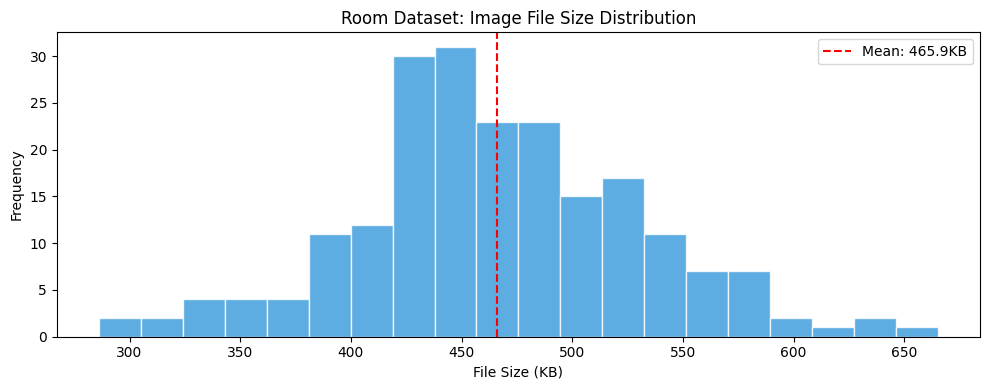

In [20]:
if all_images:
    widths, heights, file_sizes = [], [], []
    for img_name in all_images:
        img_path = os.path.join(IMAGES_PATH, img_name)
        img = Image.open(img_path)
        widths.append(img.size[0])
        heights.append(img.size[1])
        file_sizes.append(os.path.getsize(img_path) / 1024)
    
    print(f"Image Dimensions: {widths[0]}x{heights[0]}")
    print(f"Resolution Consistency: {'Uniform' if len(set(widths)) == 1 and len(set(heights)) == 1 else 'Variable'}")
    print(f"File Size - Mean: {np.mean(file_sizes):.1f}KB, Range: [{min(file_sizes):.1f}, {max(file_sizes):.1f}]KB")
    print(f"Total Dataset Size: {sum(file_sizes)/1024:.2f}MB")
    
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.hist(file_sizes, bins=20, color='#3498db', edgecolor='white', alpha=0.8)
    ax.axvline(np.mean(file_sizes), color='red', linestyle='--', label=f'Mean: {np.mean(file_sizes):.1f}KB')
    ax.set_xlabel('File Size (KB)')
    ax.set_ylabel('Frequency')
    ax.set_title('Room Dataset: Image File Size Distribution')
    ax.legend()
    plt.tight_layout()
    plt.show()

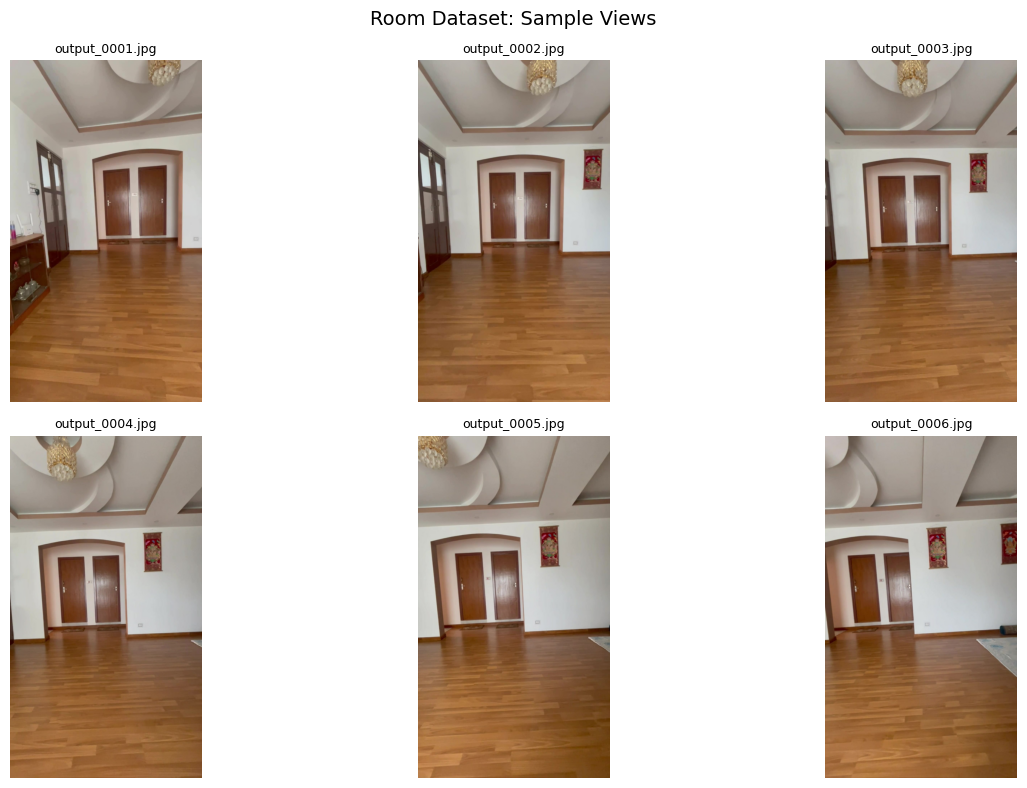

In [21]:
if all_images:
    sample_images = sorted(all_images)[:6]
    fig, axes = plt.subplots(2, 3, figsize=(14, 8))
    
    for idx, img_name in enumerate(sample_images):
        img = Image.open(os.path.join(IMAGES_PATH, img_name))
        ax = axes[idx // 3, idx % 3]
        ax.imshow(img)
        ax.set_title(f'{img_name}', fontsize=9)
        ax.axis('off')
    
    plt.suptitle('Room Dataset: Sample Views', fontsize=14)
    plt.tight_layout()
    plt.show()

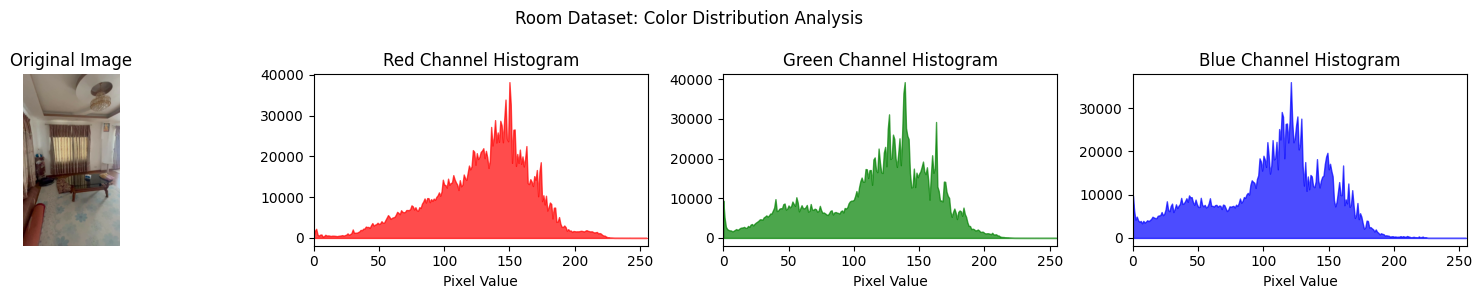

Brightness Stats - Mean: 124.7, Std: 9.8
Lighting Consistency: Good  (std < 30 = consistent)


In [22]:
if all_images:
    sample_img = cv2.imread(os.path.join(IMAGES_PATH, all_images[0]))
    sample_img_rgb = cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB)
    
    fig, axes = plt.subplots(1, 4, figsize=(16, 3))
    
    axes[0].imshow(sample_img_rgb)
    axes[0].set_title('Original Image')
    axes[0].axis('off')
    
    colors = ['red', 'green', 'blue']
    for i, (color, name) in enumerate(zip(colors, ['Red', 'Green', 'Blue'])):
        hist = cv2.calcHist([sample_img_rgb], [i], None, [256], [0, 256])
        axes[i+1].fill_between(range(256), hist.flatten(), alpha=0.7, color=color)
        axes[i+1].set_xlim([0, 256])
        axes[i+1].set_title(f'{name} Channel Histogram')
        axes[i+1].set_xlabel('Pixel Value')
    
    plt.suptitle('Room Dataset: Color Distribution Analysis', fontsize=12)
    plt.tight_layout()
    plt.show()
    
    brightness_values = []
    for img_name in all_images[:50]:
        img = cv2.imread(os.path.join(IMAGES_PATH, img_name))
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        brightness_values.append(np.mean(gray))
    
    print(f"Brightness Stats - Mean: {np.mean(brightness_values):.1f}, Std: {np.std(brightness_values):.1f}")
    print(f"Lighting Consistency: {'Good' if np.std(brightness_values) < 30 else 'Variable'}  (std < 30 = consistent)")

In [23]:
sparse_path = os.path.join(ROOM_PATH, 'sparse', '0')
if os.path.exists(sparse_path):
    sparse_files = os.listdir(sparse_path)
    print(f"COLMAP Sparse Reconstruction Files: {sparse_files}")
    
    for f in sparse_files:
        size = os.path.getsize(os.path.join(sparse_path, f)) / 1024
        print(f"  {f}: {size:.1f}KB")
else:
    print("COLMAP sparse reconstruction not found")

depth_path = os.path.join(ROOM_PATH, 'depth')
if os.path.exists(depth_path):
    depth_files = [f for f in os.listdir(depth_path) if f.endswith(('.png', '.npy'))]
    print(f"\nDepth Maps Available: {len(depth_files)}")
else:
    print("\nNo depth maps found")

COLMAP Sparse Reconstruction Files: ['points3D.bin', 'cameras.bin', 'images.bin']
  points3D.bin: 2575.2KB
  cameras.bin: 0.1KB
  images.bin: 12655.8KB

Depth Maps Available: 209


In [25]:
!python utils/make_depth_scale.py --base_dir /kaggle/working/colmap_output --depths_dir /kaggle/working/colmap_output/depth

0


In [26]:
!python train.py -s "/kaggle/working/colmap_output" -d "/kaggle/working/colmap_output/depth" --eval --test_iterations 7000 --save_iterations 7000

2026-01-17 14:04:57.477636: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1768658697.498789    1127 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1768658697.505554    1127 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1768658697.522804    1127 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768658697.522831    1127 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768658697.522834    1127 computation_placer.cc:177] computation placer alr

In [30]:
CUSTOM_MODEL_PATH = "/kaggle/working/gaussian-splatting/output/49fa1eda-3"  
CUSTOM_ITERATIONS = 7000
render_cmd = f"""
python render.py \
    -m {CUSTOM_MODEL_PATH} \
    --skip_train \
    --iteration {CUSTOM_ITERATIONS}
"""

print("Rendering Room test views...")
!{render_cmd}

print(f"Renders saved to: {CUSTOM_MODEL_PATH}/test/ours_{CUSTOM_ITERATIONS}/renders")

Rendering Room test views...
Looking for config file in /kaggle/working/gaussian-splatting/output/49fa1eda-3/cfg_args
Config file found: /kaggle/working/gaussian-splatting/output/49fa1eda-3/cfg_args
Rendering /kaggle/working/gaussian-splatting/output/49fa1eda-3
Loading trained model at iteration 7000 [17/01 15:38:05]
------------LLFF HOLD------------- [17/01 15:38:06]
Reading camera 209/209 [17/01 15:38:06]
Loading Training Cameras [17/01 15:38:06]
Loading Test Cameras [17/01 15:38:23]
Rendering progress: 100%|███████████████████████| 27/27 [00:23<00:00,  1.14it/s]
Renders saved to: /kaggle/working/gaussian-splatting/output/49fa1eda-3/test/ours_7000/renders


In [31]:
eval_cmd = f"""
python metrics.py \
    -m {CUSTOM_MODEL_PATH}
"""

print("Evaluating Room model...")
!{eval_cmd}

Evaluating Room model...

Scene: /kaggle/working/gaussian-splatting/output/49fa1eda-3
Method: ours_7000
Metric evaluation progress: 100%|███████████████| 27/27 [00:42<00:00,  1.59s/it]
  SSIM :    0.9327080
  PSNR :   26.7748337
  LPIPS:    0.2126993



In [32]:
import json

room_results_file = f"{CUSTOM_MODEL_PATH}/results.json"

if os.path.exists(room_results_file):
    with open(room_results_file, 'r') as f:
        room_results = json.load(f)
    
    print("Room Dataset - Evaluation Metrics:")
    print("=" * 50)
    for key, value in room_results.items():
        if isinstance(value, dict):
            print(f"\n{key}:")
            for k, v in value.items():
                if k in ['SSIM', 'PSNR', 'LPIPS']:
                    print(f"  {k}: {v:.7f}")
                else:
                    print(f"  {k}: {v}")
        else:
            print(f"{key}: {value}")
    print("=" * 50)
else:
    print("Room results file not found. Run evaluation first.")

Room Dataset - Evaluation Metrics:

ours_7000:
  SSIM: 0.9327080
  PSNR: 26.7748337
  LPIPS: 0.2126993


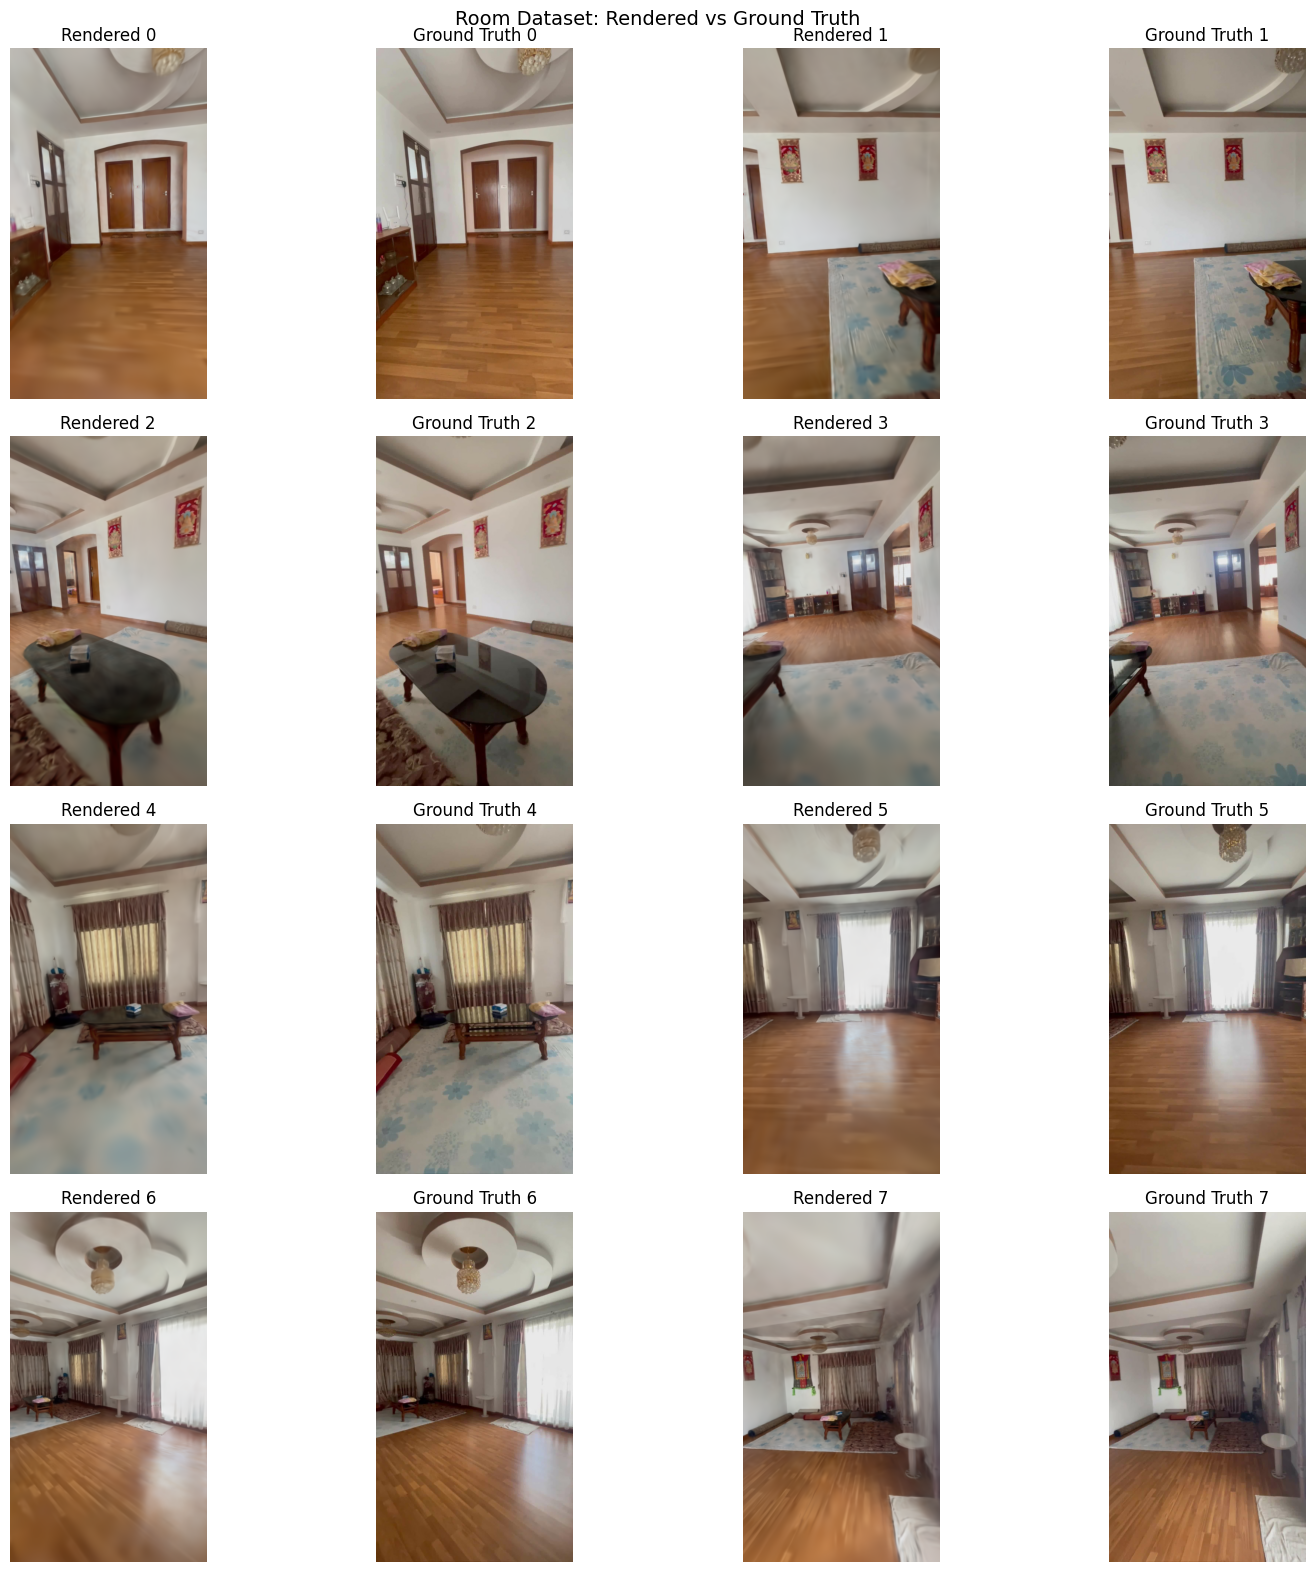

In [33]:
renders_path = f"{CUSTOM_MODEL_PATH}/test/ours_{CUSTOM_ITERATIONS}/renders"
gt_path = f"{CUSTOM_MODEL_PATH}/test/ours_{CUSTOM_ITERATIONS}/gt"

if os.path.exists(renders_path):
    render_files = sorted(os.listdir(renders_path))[:8]
    
    fig, axes = plt.subplots(4, 4, figsize=(16, 16))
    
    for idx, img_file in enumerate(render_files):
        render_img = Image.open(os.path.join(renders_path, img_file))
        gt_img = Image.open(os.path.join(gt_path, img_file))
        
        axes[idx*2//4, (idx*2)%4].imshow(render_img)
        axes[idx*2//4, (idx*2)%4].set_title(f'Rendered {idx}')
        axes[idx*2//4, (idx*2)%4].axis('off')
        
        axes[idx*2//4, (idx*2)%4 + 1].imshow(gt_img)
        axes[idx*2//4, (idx*2)%4 + 1].set_title(f'Ground Truth {idx}')
        axes[idx*2//4, (idx*2)%4 + 1].axis('off')
    
    plt.suptitle('Room Dataset: Rendered vs Ground Truth', fontsize=14)
    plt.tight_layout()
    plt.show()
else:
    print("Renders not found. Run rendering first.")

In [ ]:
custom_video_path = f"output/videos/{CUSTOM_SCENE_NAME}_render.mp4"
os.makedirs("output/videos", exist_ok=True)

custom_renders_path = f"{CUSTOM_MODEL_PATH}/test/ours_{CUSTOM_ITERATIONS}/renders"

custom_ffmpeg_cmd = f"""
ffmpeg -y -framerate 30 -pattern_type glob -i '{custom_renders_path}/*.png' \
    -c:v libx264 -pix_fmt yuv420p -crf 18 {custom_video_path}
"""

!{custom_ffmpeg_cmd}
print(f"Video saved: {custom_video_path}")

from IPython.display import Video
Video(custom_video_path, width=800)

In [35]:
room_ply_path = f"{CUSTOM_MODEL_PATH}/point_cloud/iteration_{CUSTOM_ITERATIONS}/point_cloud.ply"

if os.path.exists(room_ply_path):
    print(f"Room point cloud saved at: {room_ply_path}")
    
    from plyfile import PlyData
    plydata = PlyData.read(room_ply_path)
    
    print(f"Number of points: {plydata['vertex'].count}")
    print(f"Properties: {plydata['vertex'].properties}")
else:
    print("Room point cloud not found")

Room point cloud saved at: /kaggle/working/gaussian-splatting/output/49fa1eda-3/point_cloud/iteration_7000/point_cloud.ply
Number of points: 467277
Properties: (PlyProperty('x', 'float'), PlyProperty('y', 'float'), PlyProperty('z', 'float'), PlyProperty('nx', 'float'), PlyProperty('ny', 'float'), PlyProperty('nz', 'float'), PlyProperty('f_dc_0', 'float'), PlyProperty('f_dc_1', 'float'), PlyProperty('f_dc_2', 'float'), PlyProperty('f_rest_0', 'float'), PlyProperty('f_rest_1', 'float'), PlyProperty('f_rest_2', 'float'), PlyProperty('f_rest_3', 'float'), PlyProperty('f_rest_4', 'float'), PlyProperty('f_rest_5', 'float'), PlyProperty('f_rest_6', 'float'), PlyProperty('f_rest_7', 'float'), PlyProperty('f_rest_8', 'float'), PlyProperty('f_rest_9', 'float'), PlyProperty('f_rest_10', 'float'), PlyProperty('f_rest_11', 'float'), PlyProperty('f_rest_12', 'float'), PlyProperty('f_rest_13', 'float'), PlyProperty('f_rest_14', 'float'), PlyProperty('f_rest_15', 'float'), PlyProperty('f_rest_16', 'fl

In [36]:
!zip -r point_cloud_room_iter7000.zip \
    {CUSTOM_MODEL_PATH}/point_cloud/iteration_{CUSTOM_ITERATIONS}/point_cloud.ply

  adding: kaggle/working/gaussian-splatting/output/49fa1eda-3/point_cloud/iteration_7000/point_cloud.ply (deflated 18%)


In [37]:
import shutil

print("Saving Room dataset important files...")

room_files_to_keep = [
    f"{CUSTOM_MODEL_PATH}/point_cloud/iteration_{CUSTOM_ITERATIONS}/point_cloud.ply",
    f"{CUSTOM_MODEL_PATH}/cameras.json",
    f"{CUSTOM_MODEL_PATH}/results.json",
]

for file_path in room_files_to_keep:
    if os.path.exists(file_path):
        print(f" {file_path}")
    else:
        print(f"{file_path} not found")

print("\nRoom model training complete!")
print(f"Model saved at: {CUSTOM_MODEL_PATH}")
print(f"Renders saved at: {CUSTOM_MODEL_PATH}/test/ours_{CUSTOM_ITERATIONS}/renders")

Saving Room dataset important files...
 /kaggle/working/gaussian-splatting/output/49fa1eda-3/point_cloud/iteration_7000/point_cloud.ply
 /kaggle/working/gaussian-splatting/output/49fa1eda-3/cameras.json
 /kaggle/working/gaussian-splatting/output/49fa1eda-3/results.json

Room model training complete!
Model saved at: /kaggle/working/gaussian-splatting/output/49fa1eda-3
Renders saved at: /kaggle/working/gaussian-splatting/output/49fa1eda-3/test/ours_7000/renders


In [ ]:
print("=" * 80)
print("ROOM DATASET - TRAINING SUMMARY")
print("=" * 80)
print(f"Scene: {CUSTOM_SCENE_NAME}")
print(f"Source Path: {CUSTOM_SOURCE_PATH}")
print(f"Model Path: {CUSTOM_MODEL_PATH}")
print(f"Iterations: {CUSTOM_ITERATIONS}")
print()

if os.path.exists(f"{CUSTOM_MODEL_PATH}/results.json"):
    with open(f"{CUSTOM_MODEL_PATH}/results.json", 'r') as f:
        results = json.load(f)
    print("Metrics:")
    for key, value in results.items():
        if isinstance(value, dict):
            for k, v in value.items():
                if k in ['SSIM', 'PSNR', 'LPIPS']:
                    print(f"  {k}: {v:.7f}")

print()
print("Output Files:")
print(f"  - Model: {CUSTOM_MODEL_PATH}")
print(f"  - Renders: {CUSTOM_MODEL_PATH}/test/ours_{CUSTOM_ITERATIONS}/renders")
print(f"  - Point Cloud: {CUSTOM_MODEL_PATH}/point_cloud/iteration_{CUSTOM_ITERATIONS}/point_cloud.ply")
print("=" * 80)